# <center> MA5851 Assessment 3 Part 2: 
##    <center> WebCrawler <center> 
#### <center> __James Watts__<center> 
#### <center> James Cook University <center> 
#### <center> April 2021 <center> 
*** 
*** 

### <center>Introduction<center>
The goal of this NLP solution is “To incorporate the insights of human discussion about NBA player performance as a datapoint into a statistical pricing model for NBA player performance. 
With this goal in mind a WebCrawler was constructed to harvest discussions about NBA player performances. There are many forums on the internet that discuss players and games in great detail, as is the case with a lot of internet forums and discussions about sports stars there is often colourful language involved.  The following concurrently walks through the methodology of the python code along with discussion about why different steps were taken when considering why specific websites were chosen, what content was attempted to be extracted, additional metadata, layout complexity and website/copyright issues.



#### Step 1: Set module library for assessments
The library of python modules was set up as below. For consistency and to limit potential coding errors the list was kept identical for part 2 and 3 irrespective of which modules were called so that it can be run cleanly as a single prototype or seperatly.


In [6]:
#Module list
import os
import pandas as pd
import numpy as np
from random import shuffle
from statistics import mean
import string
import time
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
import re
import scrapy
import urllib.request
from urllib.parse import quote 
from itertools import chain
import praw 

import pyspark.sql.functions as f

import spacy
nlp = spacy.load("en_core_web_sm")

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
nltk.download(['names','stopwords','averaged_perceptron_tagger','vader_lexicon','punkt'])
stemmer = SnowballStemmer("english")

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel

#Set working directory for project
os.chdir('C:\\Users\\jmjou\\Documents\\DataScience\\MA5851 Data Science Master Class 1\\Assesment 3')
os.getcwd()

'C:\\Users\\jmjou\\Documents\\DataScience\\MA5851 Data Science Master Class 1\\Assesment 3'

#### Step 2: Player list and baseline player metadata
Before any WebCrawler was actioned a target list needed to be created containing the currently active players along with player metadata that can be used in weigh outputs for further parts of the model. The website used  that was chosen to extract the player list from was www.basketball-reference.com, this is a site that specialises in collating, summarising and publishing statistics for NBA, there is a rich volume of data available in easily digestible forms at many levels from play-by-play to high level aggregated summaries.  
As shown in the image below the player data featuring a high-level summary of all the active players in the NBA this season is available in table format at the extension leagues/NBA_2021_advanced.html. This table was easily is easily translated into a dataframe by using read_html in conjunction with .loc[] to link players and their relevant VORP statistic into a readable dataframe in the python terminal.
Player name and the statistic Value Over Replacement Player (VORP) will be used later as benchmark against sentiment in the forums. VORP was selected as it is measure that is comparable across all players, easily scalable and represents the value of a player like for like.


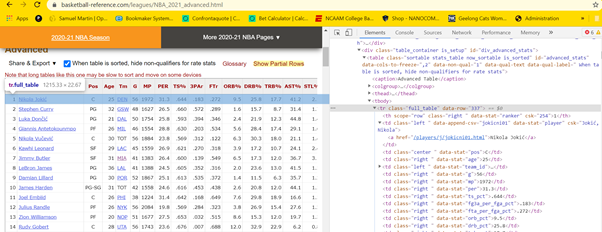

This site has an excellent layout of data in easily accessible forms, while the is made freely available for use in academic studies such as here, in practice a commercialised model that would use an API and possibly customer file structure would have to be negotiated for fee separately.

In [3]:
url = "https://www.basketball-reference.com/leagues/NBA_2021_advanced.html"
html = requests.get(url).content                   # Get player stats from BB_reference
df_list = pd.read_html(html)                       # Converts HTML to readable list
df = pd.DataFrame(df_list[-1])                     # Pass to dataframe
df = df.loc[df['Player'] != 'Player']              # remove rows repeating coloumn names
df = df.sort_values(by ='VORP' , ascending=False)  # Sort players by Value over replacemnet
df                                                 # Show dataframe

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP
337,254,Nikola Jokić,C,25,DEN,56,1972,31.3,.644,.183,...,NaN,9.8,2.7,12.5,.305,NaN,9.3,2.6,11.9,6.9
149,113,Stephen Curry,PG,32,GSW,49,1664,26.7,.663,.576,...,NaN,5.5,1.8,7.2,.209,NaN,8.2,0.1,8.3,4.4
169,126,Luka Dončić,PG,21,DAL,50,1754,25.8,.593,.394,...,NaN,4.2,2.0,6.3,.171,NaN,6.5,0.8,7.4,4.2
17,12,Giannis Antetokounmpo,PF,26,MIL,47,1583,28.9,.630,.203,...,NaN,5.2,2.7,7.9,.240,NaN,6.0,2.6,8.6,4.2
647,488,Nikola Vučević,C,30,TOT,57,1917,23.9,.571,.312,...,NaN,3.4,2.5,5.9,.147,NaN,5.6,0.3,5.8,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,439,Landry Shamet,SG,23,BRK,45,935,10.5,.582,.737,...,NaN,0.7,0.4,1.2,.061,NaN,-1.0,-1.5,-2.5,-0.1
360,267,Nathan Knight,PF,23,ATL,25,211,12.4,.494,.320,...,NaN,-0.1,0.2,0.2,.039,NaN,-3.1,-1.6,-4.7,-0.1
367,272,Rodions Kurucs,SF-PF,22,TOT,20,121,6.7,.441,.656,...,NaN,-0.3,0.2,-0.1,-0.040,NaN,-6.6,2.5,-4.1,-0.1
369,272,Rodions Kurucs,SF,22,HOU,11,75,0.9,.297,.714,...,NaN,-0.4,0.1,-0.3,-0.172,NaN,-10.4,2.1,-8.3,-0.1


#### Step 3: <center>WebCrawl Part 1:<center>

*Convert target list into a list of potential URL’s related to player discussions.*
    
There are many forum websites where contributors can openly discuss the specifics of NBA player performance, these contributors often use colourful language is intended to be leveraged when constructing a sentiment analysis framework. The popularity NBA in combination of the rise of Daily Fantasy Sports in the United states have created a situation where a significant population of people are focused on the nuances of individual performances are willing to discuss them regularly on open forums (Dixon, 2021).These discussion expressing opinions formed the target data that was used to construct the text corpus for the NLP tasks. 
    
The website chosen to run this WebCrawl on was edge-forums hosted by nbcsports. It is an open forum, not behind a paywall that any member of the public can view and interact with. This site has a consistent html structure that enables constant text extraction. The biggest attraction in this iteration of the prototype model was that sub forum discussions are split by individual NBA players. This division allows text extracted to be tagged with a specific player that allows supervise learning for further sentiment analysis. Although not examined in this prototype another NLP target would be to train an entity recognizer to identify when a particular NBA player was being discussed. Such a feature would enable further WebCralwers to be employed on forums that don’t explicitly list the players being discussed such as the sub reddits /nnadisscussion and /nba or sites like bleacherreport.


As shown in the image below *inspect* was used on the first page of the discussion board to demonstrate the html structure. This revealed that url links have a constant tagging format that can be iterated over. The below code parses the page content through *BeautifulSoup* and iterates over all the links available on first page of the forum and prints them to the page. 
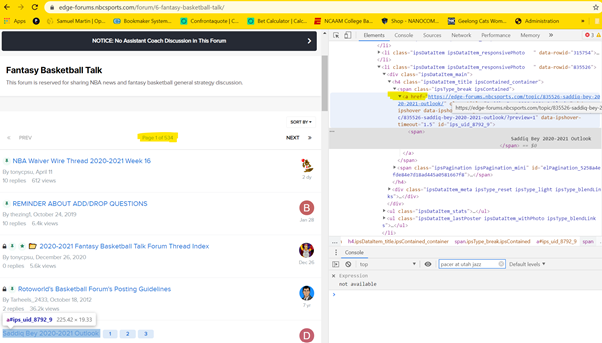

In [161]:
# Set up parser to review availible links on first page
URL = "https://edge-forums.nbcsports.com/forum/6-fantasy-basketball-talk/"
page = requests.get(URL)
soup_nbc = BeautifulSoup(page.content, 'html.parser')
for link in soup_nbc.find_all('a'):
    print(link.get('href'))

#ipsLayout_mainArea
https://www.nbcsports.com/edge/
https://www.nbcsports.com/edge/nfl
https://nbcsports.com/edge/nfl
https://edge-plus.nbcsports.com/nfl/season-pass
https://edge-plus.nbcsports.com/nfl/leaguesync
https://www.nbcsports.com/edge/football/nfl/player-news
https://www.nbcsports.com/edge/football/nfl/player-news/headlines
https://edge-plus-bet.nbcsports.com/nfl/live_odds
https://edge-plus-bet.nbcsports.com/nfl/futures
https://www.nbcsports.com/edge/features/nfl
https://www.nbcsports.com/edge/videos/football/nfl
https://www.nbcsports.com/edge/football/nfl/teams
https://www.nbcsports.com/edge/football/nfl/teams/arz/arizona-cardinals
https://www.nbcsports.com/edge/football/nfl/teams/atl/atlanta-falcons
https://www.nbcsports.com/edge/football/nfl/teams/bal/baltimore-ravens
https://www.nbcsports.com/edge/football/nfl/teams/buf/buffalo-bills
https://www.nbcsports.com/edge/football/nfl/teams/car/carolina-panthers
https://www.nbcsports.com/edge/football/nfl/teams/chi/chicago-bears
h

#### Step 4: Convert playernames to URL format

Reviewing the above output it was seen that the available URL links follow a specific format and any forum discussion that was specifically about a particular player had the players name as part of the URL link in a predictable format. 
    
This naming convention was used to our advantage, the new column player_lower was created in the player dataframe that converted player names into the URL format that will be used as a common key when referencing back to the table with processed player data. The new dataframe was backed up using top_csv() and a the new column was extracted as a list for use in matching URL's.


In [10]:
#new column - player name in url format
df['player_lower'] = df.apply(lambda row: row.Player.lower(), axis=1)             # make lowercase
df['player_lower'] = df['player_lower'].apply(lambda x: str(re.sub(' ','-',x)))   # replace spaces with hypen
df['player_lower'] = df['player_lower'].apply(lambda x: re.sub("'",'',x))         # remove apostrophe
df                                                                                # check list of playernames is in website format

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,player_lower
337,254,Nikola Jokić,C,25,DEN,56,1972,31.3,.644,.183,...,9.8,2.7,12.5,.305,NaN,9.3,2.6,11.9,6.9,nikola-jokić
149,113,Stephen Curry,PG,32,GSW,49,1664,26.7,.663,.576,...,5.5,1.8,7.2,.209,NaN,8.2,0.1,8.3,4.4,stephen-curry
169,126,Luka Dončić,PG,21,DAL,50,1754,25.8,.593,.394,...,4.2,2.0,6.3,.171,NaN,6.5,0.8,7.4,4.2,luka-dončić
17,12,Giannis Antetokounmpo,PF,26,MIL,47,1583,28.9,.630,.203,...,5.2,2.7,7.9,.240,NaN,6.0,2.6,8.6,4.2,giannis-antetokounmpo
647,488,Nikola Vučević,C,30,TOT,57,1917,23.9,.571,.312,...,3.4,2.5,5.9,.147,NaN,5.6,0.3,5.8,3.8,nikola-vučević
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,439,Landry Shamet,SG,23,BRK,45,935,10.5,.582,.737,...,0.7,0.4,1.2,.061,NaN,-1.0,-1.5,-2.5,-0.1,landry-shamet
360,267,Nathan Knight,PF,23,ATL,25,211,12.4,.494,.320,...,-0.1,0.2,0.2,.039,NaN,-3.1,-1.6,-4.7,-0.1,nathan-knight
367,272,Rodions Kurucs,SF-PF,22,TOT,20,121,6.7,.441,.656,...,-0.3,0.2,-0.1,-0.040,NaN,-6.6,2.5,-4.1,-0.1,rodions-kurucs
369,272,Rodions Kurucs,SF,22,HOU,11,75,0.9,.297,.714,...,-0.4,0.1,-0.3,-0.172,NaN,-10.4,2.1,-8.3,-0.1,rodions-kurucs


In [11]:
df.to_csv("current_player_list.csv") # backup list of players
os.getcwd()                          # confirm directory where list was saved.

'C:\\Users\\jmjou\\Documents\\DataScience\\MA5851 Data Science Master Class 1\\Assesment 3'

In [12]:
# Extract list of players to iterate over url lists.
player_list = list(set(df['player_lower'])) # Set unique list of NBA players this season
player_list[:10]                            #Show first 10 players

['semi-ojeleye',
 'john-collins',
 'ivica-zubac',
 'miye-oni',
 'darius-miller',
 'isaac-bonga',
 'p.j.-tucker',
 'nerlens-noel',
 'trey-lyles',
 'dwight-howard']

#### Step 6: 
#### WebCrawl Part 2:
*Extract comments related to current players from disscusion*

Forum link matching was tested on the first page of the discussion board. a new dataframe was constructed to store the results of the scraper, the available links were scanned and any that matched with the player list were returned to the new dataframe.

In [14]:
forum_pages = []                                                     # Set blank dataframe
forum_pages = pd.DataFrame(forum_pages, columns=('Player','URL','comments'))

for link in soup_nbc.find_all('a'):         # iterate over each link
    test_url = link.get('href')             
    for player in player_list:              # scan link against player names
        if player in test_url:
            features = {'Player':player,'URL':test_url}
            forum_pages = forum_pages.append(features, ignore_index = True)


forum_pages.head()

,Player,URL,comments
0,shai-gilgeous-alexander,https://edge-forums.nbcsports.com/topic/831131...,NaN
1,shai-gilgeous-alexander,https://edge-forums.nbcsports.com/topic/831131...,NaN
2,shai-gilgeous-alexander,https://edge-forums.nbcsports.com/topic/831131...,NaN
3,shai-gilgeous-alexander,https://edge-forums.nbcsports.com/topic/831131...,NaN
4,shai-gilgeous-alexander,https://edge-forums.nbcsports.com/topic/831131...,NaN


#### Step 7: <center>WebCrawl Part 2 cont.<center>
Now that the URL linking was shown to work the process was expanded over the next 200 tabs. As the tabs were numbed in a consistent fashion URL’s were iterated over by running a simple a loop through the page permutations.

*Warning this takes a few minutes to run.*


In [15]:
page_tab = list(range(2,202))  #List the next 200 tabs to search 
base_url = "https://edge-forums.nbcsports.com/forum/6-fantasy-basketball-talk/page/" 

for page in page_tab:                                   # Iterate over each page tab
    url_fetch = "https://edge-forums.nbcsports.com/forum/6-fantasy-basketball-talk/page/"+str(page)
    soup_nbc = BeautifulSoup(requests.get(url_fetch).content, 'html.parser')
    for link in soup_nbc.find_all('a'):                 # Iterate over each url found on the tab
        test_url = link.get('href')
        for player in player_list:                      # Scan URL against player list for a match
            if player in test_url:
                features = {'Player':player,'URL':test_url}
                forum_pages = forum_pages.append(features, ignore_index = True)

forum_pages.drop_duplicates()                           # remove duplicate links
forum_pages

,Player,URL,comments
0,shai-gilgeous-alexander,https://edge-forums.nbcsports.com/topic/831131...,NaN
1,shai-gilgeous-alexander,https://edge-forums.nbcsports.com/topic/831131...,NaN
2,shai-gilgeous-alexander,https://edge-forums.nbcsports.com/topic/831131...,NaN
3,shai-gilgeous-alexander,https://edge-forums.nbcsports.com/topic/831131...,NaN
4,shai-gilgeous-alexander,https://edge-forums.nbcsports.com/topic/831131...,NaN
...,...,...,...
9209,james-johnson,https://edge-forums.nbcsports.com/topic/317254...,NaN
9210,garrett-temple,https://edge-forums.nbcsports.com/topic/331471...,NaN
9211,garrett-temple,https://edge-forums.nbcsports.com/topic/331471...,NaN
9212,jared-dudley,https://edge-forums.nbcsports.com/topic/327165...,NaN


In [413]:
forum_pages.to_csv("player_lookuplist.csv") # backup list of forum's url assosiated with each player
os.getcwd()                                 # confrim location of save 

'C:\\Users\\jmjou\\Documents\\DataScience\\MA5851 Data Science Master Class 1\\Assesment 3'

In [16]:
print(len(forum_pages),"forum links found")

9214 forum links found


#### Step 7: <center>WebCrawl Part3<center>
The next step now that the target pages have been obtained was to Crawl through the list of targets and extract the meaningful information. 
The WebCrawler was set to iterate its way through the list of attained URL’s related to the players. BeautifulSoup was used to call each iteration and extract the user comments of the page by referencing the html structure. Timeout of 2 seconds was implemented as to limit the request frequency on the website.  The comments have a consistent HTML structure that is show in the screenshot below using inspect. This structure was leverages and comments on each page to be found by reading the children of attrs={'data-role':'commentContent'}). 
    
Before data was passed back to the dataframe it underwent some pre-processing by flattening the text stripping any new lines to condense a collection of comments to a single piece of text for processing.

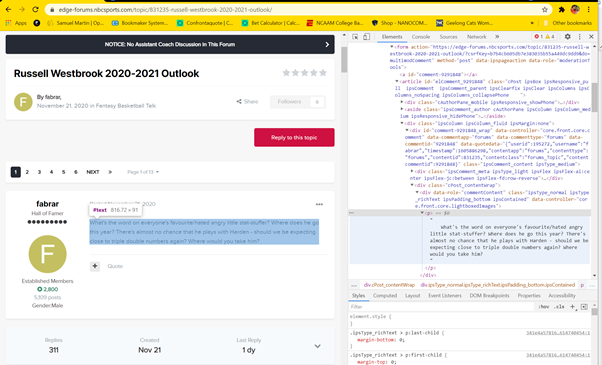

In [17]:
rows = list(range(1,len(forum_pages)))     # All rows to iterate over 

In [468]:
for row in rows: 
    try: 
        comments = []                                                              # Set blank template for comments
        row_url = forum_pages.loc[forum_pages.index[row],'URL']                    # URL to fecth from
        soup_test = BeautifulSoup(requests.get(row_url, timeout=2).content, 'html.parser')    # Parse html set timeout value of 3 secounds per request
        comment = soup_test.find_all('div', attrs={'data-role':'commentContent'})  # source comments forum users about player on that page                                                     
        comments.append(comment)
        flat = [item for sublist in comments for item in sublist]                  # flaten all comments into a single item
        disscussion = []                                                           # set blank template for player disscussion
        for post in flat:                                               
            for paragraph in post.find_all('p'):
                txt = str(paragraph.text)                                          # convert to text
                disscussion.append(txt)
                disscussion = [i.strip("'\n\t\t\t") for i in disscussion]
                disscussion = [i.strip("\xa0") for i in disscussion]
                forum_pages.loc[forum_pages.index[row],'comments'] = disscussion
    except: 
        forum_pages.loc[forum_pages.index[row],'comments'] = "Check_error"
forum_pages.to_csv("player_comments.csv") # backup


#### Step 8: Review WebCrawl output
Summary of the web scraper output is seen below. Of the 9193 URL’s that were read approximately 1 in 3 pages were duplicate content. The dataframe was condensed to remove these duplicates along with the URL and duplicate index column, this was then saved for use in the next NLP section. Additionally, the comments were also grouped by individual players so the full corpus of comments for each of the 375 players that had comments can be reviewed in the next section. 

In [23]:
forum_pages # Show output

,Index,Player,URL,comments
0,0,kyle-lowry,https://edge-forums.nbcsports.com/topic/831774...,"[""What's the word on everyone's favourite/hate..."
1,1,kyle-lowry,https://edge-forums.nbcsports.com/topic/831774...,"['With the previous big men moving, will he pe..."
2,2,kyle-lowry,https://edge-forums.nbcsports.com/topic/831774...,"['LOLLLLLLL', '', 'True I am a newbie to Baske..."
3,3,kyle-lowry,https://edge-forums.nbcsports.com/topic/831774...,['Just traded for him. Looking forward to anot...
4,4,kyle-lowry,https://edge-forums.nbcsports.com/topic/831774...,"[""Won't return"", 'https://www.twitter.com/Rapt..."
...,...,...,...,...
9188,9175,james-johnson,https://edge-forums.nbcsports.com/topic/317254...,"[""Okay, so he's apparently starting for the Ki..."
9189,9176,garrett-temple,https://edge-forums.nbcsports.com/topic/331471...,['Garrett Temple scored 13 points on 6-of-8 sh...
9190,9177,garrett-temple,https://edge-forums.nbcsports.com/topic/331471...,['Garrett Temple scored 13 points on 6-of-8 sh...
9191,9178,jared-dudley,https://edge-forums.nbcsports.com/topic/327165...,['Phoenix guard Jared Dudley joined the starti...


In [259]:
comments_df = forum_pages[['Player','comments']] #Subset player and forum comments
print('Player comments query returned', len(comments_df), 'responses.')
comments_df = comments_df.dropna(axis = 0)           # Remove any rows that failed to populate
comments_df = comments_df.drop_duplicates()          # Remove any duplicatae rows
print('There were', len(comments_df), 'unique pages of player comments reviewd.')
comments_df['comments'] = comments_df[['Player','comments']].groupby('Player')['comments'].transform(lambda x: ','.join(x)) 
player_df = comments_df[['Player','comments']].drop_duplicates()
print('There were comments for', len(player_df), 'unique players.')
player_df.head()

Player comments query returned 9193 responses.
There were 6159 unique pages of player comments reviewd.
There were comments for 375 unique players.


,Player,comments
0,kyle-lowry,"[""What's the word on everyone's favourite/hate..."
7,bradley-beal,['Just noticed in the 2019-2020 thread a lot o...
14,julius-randle,"[""Can't believe there's no thread for my Week ..."
18,donovan-mitchell,"['Just signed a max extension, he\xa0celebrate..."
23,shai-gilgeous-alexander,"['So, with the Rubio trade, is he rocketing up..."


In [88]:
page_comment_player = forum_pages[['Player','comments']] #Subset player and forum comments
page_comment_player = page_comment_player.dropna(axis = 0)           # Remove any rows that failed to populate
page_comment_player = page_comment_player.drop_duplicates()          # Remove any duplicatae rows
page_comment_player

,Player,comments
0,kyle-lowry,"[""What's the word on everyone's favourite/hate..."
1,kyle-lowry,"['With the previous big men moving, will he pe..."
2,kyle-lowry,"['LOLLLLLLL', '', 'True I am a newbie to Baske..."
3,kyle-lowry,['Just traded for him. Looking forward to anot...
4,kyle-lowry,"[""Won't return"", 'https://www.twitter.com/Rapt..."
...,...,...
9184,lou-williams,"['Nobody knows except Dr. Drew ', 'Nobody know..."
9185,lou-williams,['Teague is finna eat!']
9187,james-johnson,"[""Okay, so he's apparently starting for the Ki..."
9189,garrett-temple,['Garrett Temple scored 13 points on 6-of-8 sh...


In [89]:
# Save outout for use in part 3 NLP
forum_pages.to_csv("backup_webcrawl_output.csv") 
page_comment_player.to_csv("player_post_comments.csv")  
player_df.to_csv("collated_comments.csv") 
os.getcwd()

'C:\\Users\\jmjou\\Documents\\DataScience\\MA5851 Data Science Master Class 1\\Assesment 3'

#### Production model and next steps: Non tagged discussion sites
As noted when selecting edge-forum, there are many other forums dedicated to the discussion of NBA players. The subreddit nbadiscussion is one such example, this site has the advantage that a published API is available to make downloading comments into further processing very simple as demonstrated below by connecting to Reddit with praw and quickly getting articles, these are ranked on site by different metrics such as popularity or recency adding to the potential for a reactive model. If this model was to be productionised the idea of an entity recognizer that was trained on the supervised data above could be deployed on the reddit forum comments to tag players to comments. 

In [7]:
reddit = praw.Reddit(client_id='_cAkhMdkSO4fQA', client_secret='__r77eEl_I7Hu0xnBIJODGSFVix4YQ', user_agent='player_sentiment')


Version 7.0.0 of praw is outdated. Version 7.2.0 was released Wednesday February 24, 2021.


In [8]:
import pandas as pd
posts = []
ml_subreddit = reddit.subreddit('nbadiscussion')
for post in ml_subreddit.hot(limit=100):
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])
print(posts)

                                                title  score      id  \
0   Please be civil to others in this subreddit. Y...    410  if3gvs   
1   Self-promotion thread refresh. You're free to ...     76  ktyiqk   
2   Why comparing scoring across eras by just look...    156  mtnuhi   
3   Steph Curry or Damian Lillard for all-nba 1st ...    558  mta4b8   
4   [OC] Who was the most clutch player of the 16-...     31  mtk1nb   
..                                                ...    ...     ...   
95  My biggest problems with Ben Taylor's Wilt and...    157  mlrswy   
96  (OC) Jordan isn't A Better Ceiling Raiser than...      0  mmus89   
97             Vince Carter & Kobe Bryant Career Swap      7  mm5l0g   
98  What could the league do to stop players from ...      6  mm5k46   
99  Why has De'Aaron Fox succeeded in the NBA whil...     70  mlrtdv   

        subreddit                                                url  \
0   nbadiscussion  https://www.reddit.com/r/nbadiscussion/comme

In [106]:
# get 10 hot posts from the MachineLearning subreddit
hot_posts = reddit.subreddit('nbadiscussion').hot(limit=10)
for post in hot_posts:
    print(post.title)

Please be civil to others in this subreddit. You can express any view you want, just do it respectfully. It's amazing what a difference that makes in allowing those who disagree to productively and peacefully discuss something.
Self-promotion thread refresh. You're free to self-promote in this thread (and this thread only). Share your videos, articles, podcasts, subreddits or anything else related to the NBA.
The way we discuss and reflect assists/playmaking is crazy
My Favorite LaMarcus Aldridge Story
Is it crazy to think that Steph Curry is the best player in the world right now?
Would lebron do better in steph's situation?
Any research/data on when in the shot clock players/teams tend to shoot and how that correlates with other metrics?
Why comparing scoring across eras by just looking at league average efficiency can be misleading and how Curry changed defenses.
Where does Julius Randle rank currently in the NBA?
Start, bench, cut
